<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LinearRegression()" data-toc-modified-id="LinearRegression()-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>LinearRegression()</a></span></li><li><span><a href="#Ridge()" data-toc-modified-id="Ridge()-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Ridge()</a></span></li><li><span><a href="#CatBoostRegressor()" data-toc-modified-id="CatBoostRegressor()-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>CatBoostRegressor()</a></span></li><li><span><a href="#LGBMRegressor()" data-toc-modified-id="LGBMRegressor()-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>LGBMRegressor()</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#LinearRegression()" data-toc-modified-id="LinearRegression()-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>LinearRegression()</a></span></li><li><span><a href="#Ridge()" data-toc-modified-id="Ridge()-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Ridge()</a></span></li><li><span><a href="#CatBoostRegressor()" data-toc-modified-id="CatBoostRegressor()-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>CatBoostRegressor()</a></span></li><li><span><a href="#LGBMRegressor()" data-toc-modified-id="LGBMRegressor()-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>LGBMRegressor()</a></span></li></ul></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Общий вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

Импорт необходимых библиотек

In [99]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error
from catboost import Pool, CatBoostRegressor, cv
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import TimeSeriesSplit

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

Загрузка данных и вывод на экран.

In [100]:
try:  
    data = pd.read_csv('C:/projects/taxi.csv',parse_dates=[0], index_col=[0])
except OSError as e:
    data = pd.read_csv('/datasets/taxi.csv',parse_dates=[0], index_col=[0])
display(data.head())
display(data.info())

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

Проверка хронологического порядка данных.

In [101]:
data = data.sort_index() 
display(data.index.is_monotonic)

True

Произведем ресемплирование данных по одному часу.

In [102]:
data = data.resample('1H').sum()

### Вывод
<br>
Данные были загружены и подготовлены. Артефкатов не выявлено. Также даные были ресемплированы по одному часу.

## Анализ

Создание копии таблицы

In [103]:
data_new = data.copy(deep=True)

Построение графика ск.среднего и ср.кв. отклонения по каждому месяцу.

In [104]:
def plot(data, x):
    data['rolling_mean'] = data.rolling(x).mean()
    data['std'] = data['num_orders'].rolling(x).std()
    data.plot(figsize=[10,5]);

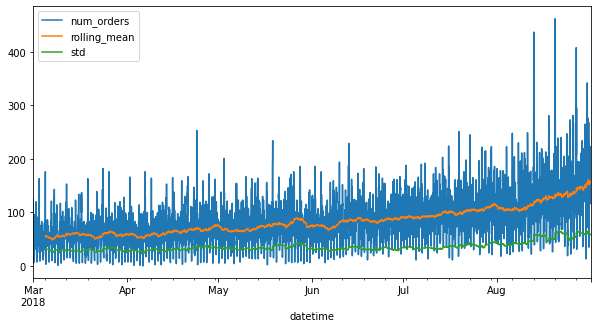

In [105]:
plot(data_new, 100)

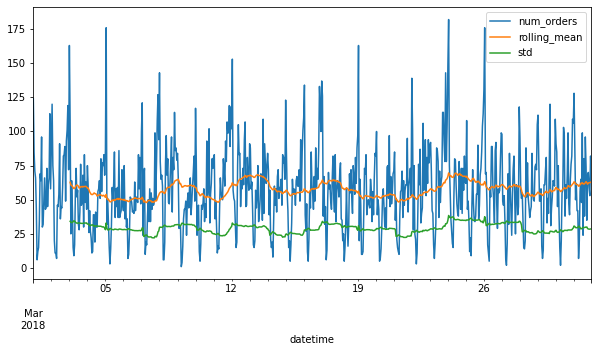

In [106]:
plot(data_new['2018-03'], 50)

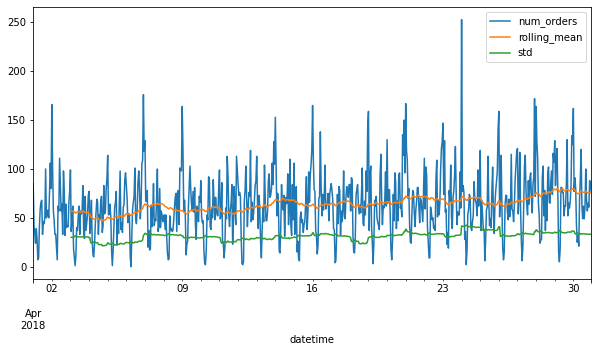

In [107]:
plot(data_new['2018-04'], 50)

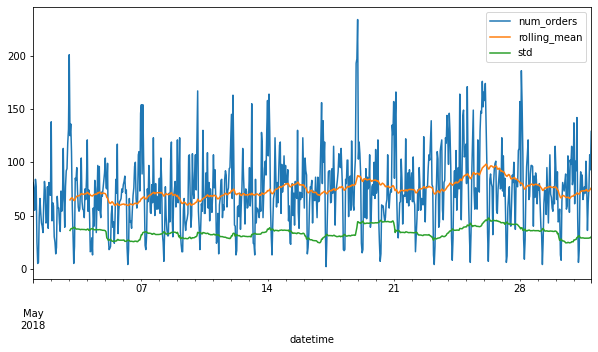

In [108]:
plot(data_new['2018-05'], 50)

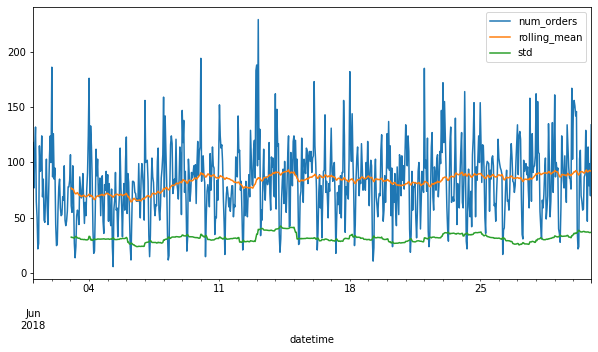

In [109]:
plot(data_new['2018-06'], 50)

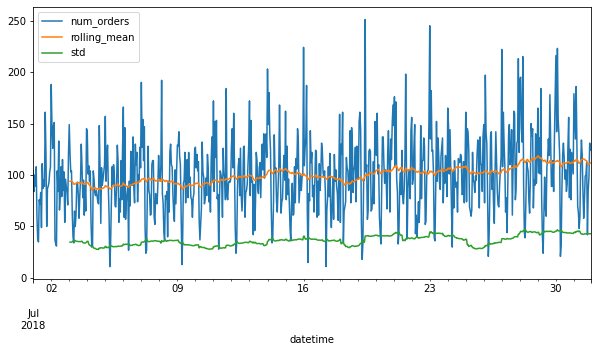

In [110]:
plot(data_new['2018-07'], 50)

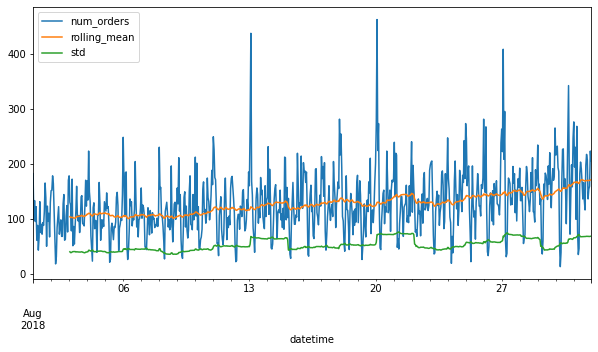

In [111]:
plot(data_new['2018-08'], 50)

По графикам видно, что пик заказов приходится на вторую половину дня и увеличиваются со временем. Высокие пики связаны с выходными днями.

Разложение временного ряда на тренд и сезонную компоненту.

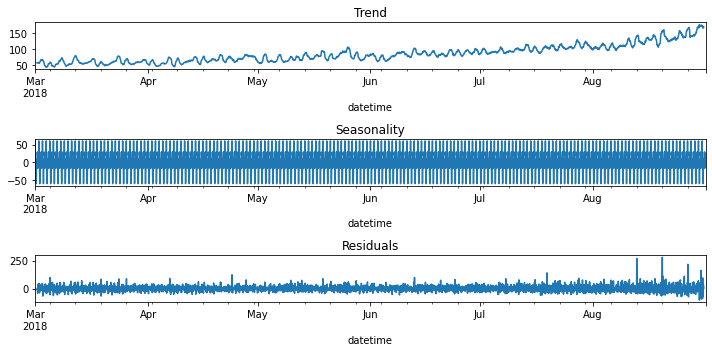

In [112]:
decomposed = seasonal_decompose(data) 

plt.figure(figsize=(10,5))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

Trend говорит о росте заказов ближе к осени.
<br>
График Seasonality цикличен.
<br>
На графике Residuals шум, с выбросами ближе к осени.

## Обучение

Проанализируем и определим наилушие гиперпараметры для след. моделей:

- LinearRegression;
- Ridge;
- CatBoostRegressor;
- LGBMRegressor.

Параметры max_lag и rolling_mean будет взято 24.

In [113]:
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

make_features(data, 24, 24)
display(data.head())

,num_orders,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,1,3,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,1,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,1,3,66.0,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Создание тренировочной и тестовой выборки.

In [114]:
train, test = train_test_split(data, shuffle=False, test_size=0.1, random_state=12345)
train = train.dropna()

features_train = train.drop('num_orders', axis=1)

target_train = train['num_orders']
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

print('Размер обучающей выборки', features_train.shape[0])
print('Размер тестовой выборки', features_test.shape[0])

Размер обучающей выборки 3950
Размер тестовой выборки 442


Подберем наилучшие гиперпараметры для моделей.

### LinearRegression()

In [115]:
%%time

model_LR = LinearRegression()
scaller = StandardScaler()
tscv = TimeSeriesSplit(n_splits=8)
pipeline = Pipeline([("standard_scaller", scaller),("linear_regression", model_LR)])
result_LR = (cross_val_score(pipeline,
                                features_train, 
                                target_train,
                                cv=tscv, 
                                scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('RMSE =', result_LR)

RMSE = 26.966776808471447
CPU times: user 526 ms, sys: 618 ms, total: 1.14 s
Wall time: 1.05 s


### Ridge()

In [116]:
%%time

model_r = Ridge()
params = [{'solver':['auto', 'svd', 'cholesky', 'lsqr','sparse_cg']}]
tscv = TimeSeriesSplit(n_splits=8)
result = GridSearchCV(model_r, params, scoring='neg_mean_squared_error',n_jobs=-1, cv=tscv,verbose=1 )
result.fit(features_train, target_train)
print("Best parametrs:", result.best_params_)
print()
means = result.cv_results_['mean_test_score']
stds = result.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, result.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()


Fitting 8 folds for each of 5 candidates, totalling 40 fits
Best parametrs: {'solver': 'svd'}

26.966145 for {'solver': 'auto'}
26.966145 for {'solver': 'svd'}
26.966145 for {'solver': 'cholesky'}
26.970259 for {'solver': 'lsqr'}
26.967101 for {'solver': 'sparse_cg'}

CPU times: user 2.16 s, sys: 2.54 s, total: 4.7 s
Wall time: 4.69 s


### CatBoostRegressor() 

In [119]:
%%time

regressor = CatBoostRegressor() 

hyperparams = [{'learning_rate':[0.01, 0.1, 0.5, 0.8],
                'iterations': [10, 20, 40],
                'depth': [2, 4, 6],
                'random_state':[12345],
                'l2_leaf_reg': [1, 3, 5],
                'verbose':[False]}]

clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(features_train, target_train)

print(clf.best_params_)

{'depth': 6, 'iterations': 40, 'l2_leaf_reg': 5, 'learning_rate': 0.5, 'random_state': 12345, 'verbose': False}
CPU times: user 48.1 s, sys: 1.76 s, total: 49.8 s
Wall time: 2min 52s


### LGBMRegressor() 

In [76]:
%%time

regressor = LGBMRegressor() 
hyperparams = [{'num_leaves':[10, 11], 
                'learning_rate':[0.01, 0.1, 0.2, 0.3],
                'min_data_in_leaf':[100, 110],
                'max_depth': [1, 2],
                'random_state':[12345]}]

result = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
result.fit(features_train, target_train)

print(result.best_params_)

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGB

Были определены наилучшие гиперпараметры для каждой модели.

## Тестирование

### LinearRegression()

CPU times: user 169 ms, sys: 136 ms, total: 305 ms
Wall time: 236 ms


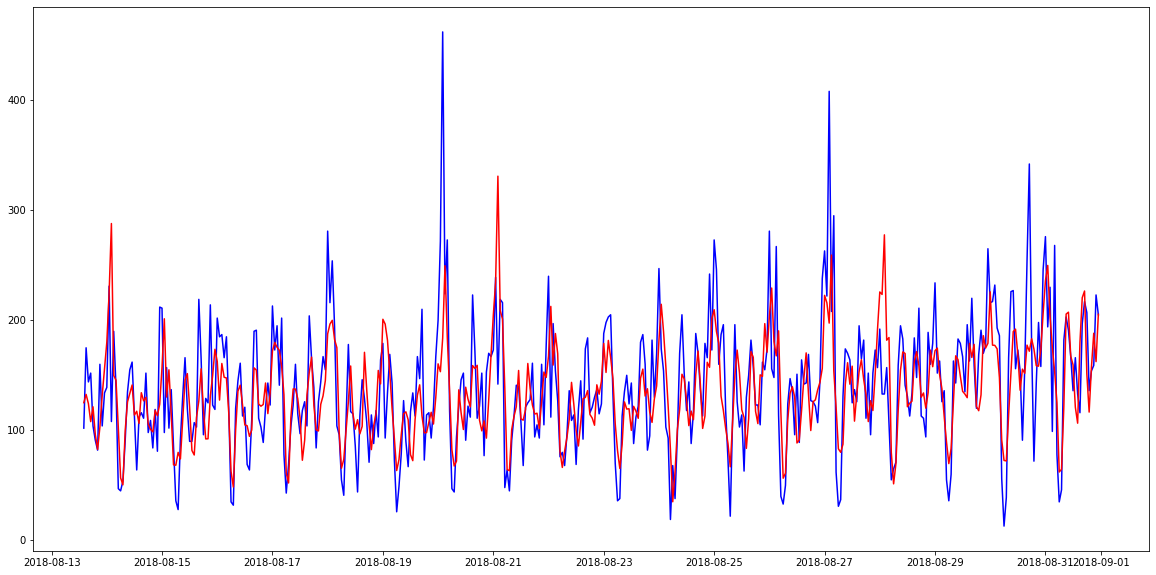

In [127]:
%%time

model = LinearRegression()
model.fit(features_train, target_train)
target_predict = model.predict(features_test)
final_RMSE_LR = mean_squared_error(target_test, target_predict) ** 0.5
final_RMSE_LR

plt.figure(figsize=(20,10));
plt.plot(target_test.index, 
         target_test, 
         'b-', 
         target_test.index, 
         target_predict,
         'r-');

### Ridge()

Best parametrs: {'solver': 'svd'}

CPU times: user 200 ms, sys: 145 ms, total: 345 ms
Wall time: 316 ms


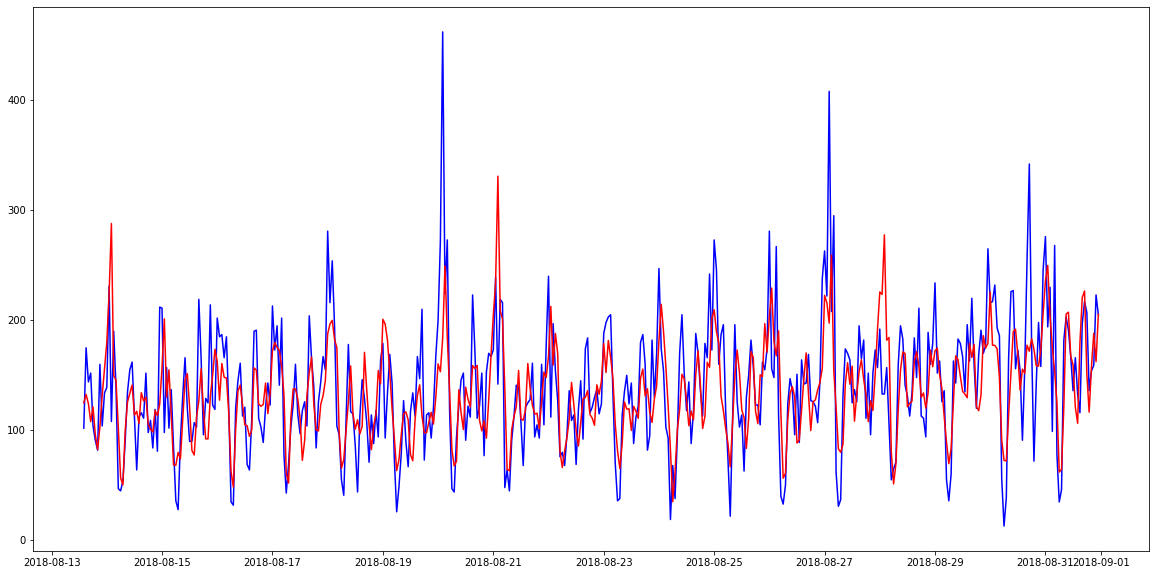

In [128]:
%%time

model = Ridge(solver='svd')
model.fit(features_train, target_train)
target_predict = model.predict(features_test)
final_RMSE_R = mean_squared_error(target_test, target_predict) ** 0.5
final_RMSE_R


plt.figure(figsize=(20,10));
plt.plot(target_test.index, 
         target_test, 
         'b-', 
         target_test.index, 
         target_predict,
         'r-');

### CatBoostRegressor() 

best param
<br>
{'depth': 6, 'iterations': 40, 'l2_leaf_reg': 5, 'learning_rate': 0.5, 'random_state': 12345, 'verbose': False}

43.62030042141176
CPU times: user 303 ms, sys: 0 ns, total: 303 ms
Wall time: 487 ms


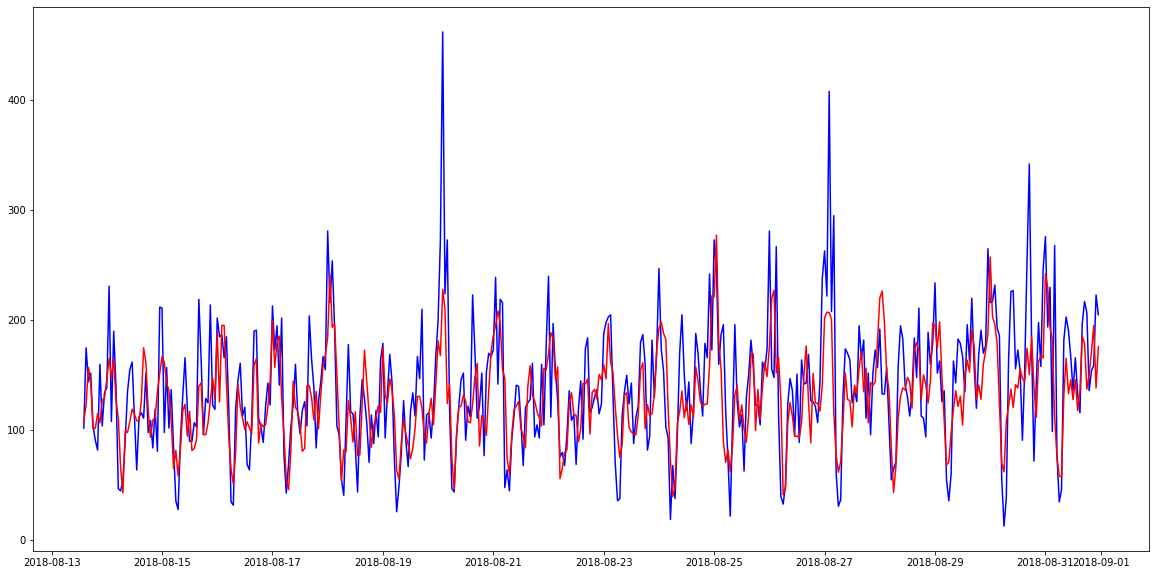

In [129]:
%%time

model_cat = CatBoostRegressor(depth=6,
                              iterations = 40,
                              l2_leaf_reg=5,
                              learning_rate=0.5,
                              verbose=False,
                              random_state=12345)
model_cat.fit(features_train, target_train)
predictions_cat = model_cat.predict(features_test)
RMSE_cat = mean_squared_error(target_test, predictions_cat) **0.5  
print(RMSE_cat)


plt.figure(figsize=(20,10));
plt.plot(target_test.index, 
         target_test, 
         'b-', 
         target_test.index, 
         predictions_cat,
         'r-');

### LGBMRegressor() 

{'learning_rate': 0.3, 'max_depth': 2, 'min_data_in_leaf': 100, 'num_leaves': 10, 'random_state': 12345}
{'learning_rate': 0.1, 'max_depth': 2, 'min_data_in_leaf': 100, 'num_leaves': 10, 'random_state': 12345}

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
46.207638946192716
CPU times: user 39.8 s, sys: 326 ms, total: 40.1 s
Wall time: 40.4 s


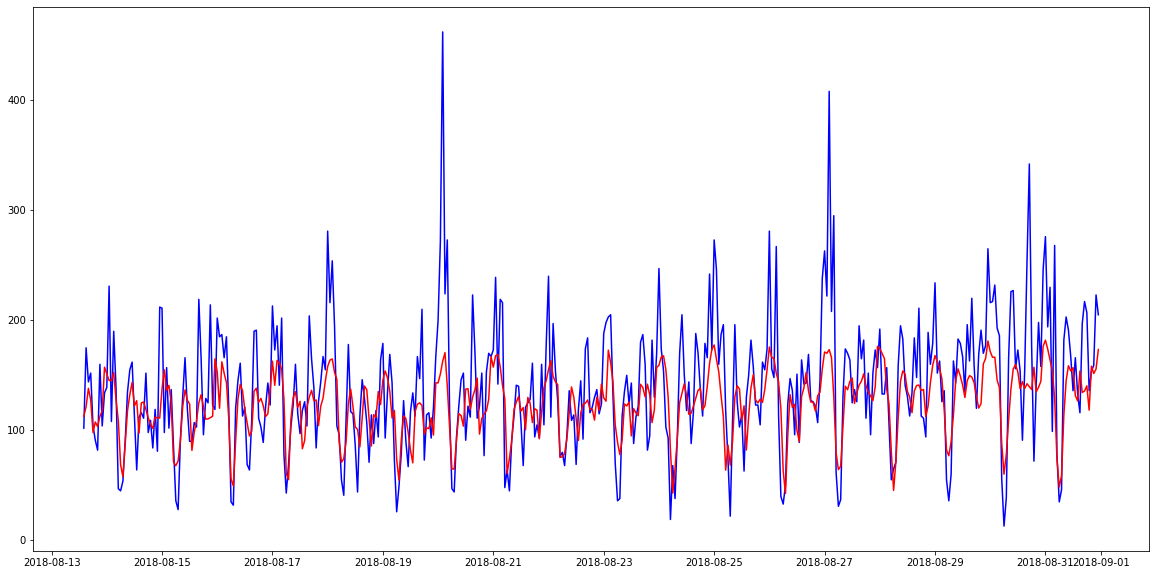

In [130]:
%%time

model_light = LGBMRegressor(max_depth=2,
                            min_data_in_leaf=100,
                            learning_rate=0.1,
                            num_leaves=10,
                            random_state=12345)
model_light.fit(features_train, target_train)
predictions_light = model_light.predict(features_test)
RMSE_light = mean_squared_error(target_test, predictions_light) **0.5  
print(RMSE_light)


plt.figure(figsize=(20,10));
plt.plot(target_test.index, 
         target_test, 
         'b-', 
         target_test.index, 
         predictions_light,
         'r-');

## Вывод

Составление таблицы по метрикам.

In [122]:
data = pd.DataFrame({'name': ['LinearRegression', 'Ridge', 'CatBoostRegressor', 'LGBMRegressor'],
                   'RMSE': [44.97, 44.98, 43.62, 46.20]})
data.sort_values(by=['RMSE'])

,name,RMSE
2,CatBoostRegressor,43.62
0,LinearRegression,44.97
1,Ridge,44.98
3,LGBMRegressor,46.20


## Общий вывод

В ходе работы было проанализирован временной ряд заказов такси. Была определена лучшая модель - CatBoostRegressor	 с гиперпараметрами: 

<br>

- depth=6,
- iterations = 40,
- l2_leaf_reg=5,
- learning_rate=0.5,
- verbose=False,
- 1random_state=12345


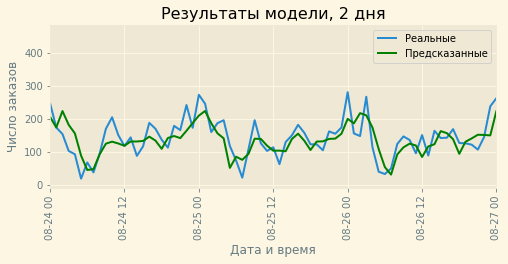